# Задача № 1.1 

Выборка состоит из трех обзектов: X_train, Y_train, X_test

- Y_train - изображение (пиксель кодируется черно-белой компонентой изображения)
- X_train - признаки, соответствующие этому изображению. (элемент $X_{i,j}$ соответствует набору признаков для пикселя $Y_{i,j}$).

Требуется:

- Провести отбор наиболее значимых признаков и построить регрессию X->Y
- Проинтерпетировать признаки (каждый признак является функцией, возможно нелинейной, от значения пикселя)
- Получить изображение по X_test (оцениваться будет качество полученного изображения. Ожидается, что регрессия на X_train, Y_train даст R^2>0.85).

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scipy
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [2]:
x_test = np.load('regression/regression_x_test.npy')
x_train = np.load('regression/regression_x_train.npy')
y_train = np.load('regression/regression_y_train.npy')

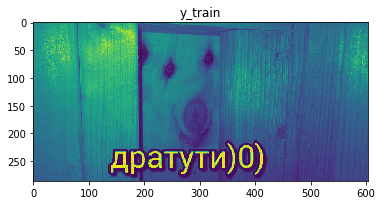

In [3]:
fig, ax = plt.subplots()
ax.imshow(y_train)
fig.set_figwidth(6)   
fig.set_figheight(6)
plt.title('y_train')
plt.show()

Очень интересно, что же за признаковое описание у этого объекта

In [4]:
x_train.shape, y_train.shape

((286, 604, 35), (286, 604))

Получается по 35 признаков

In [5]:
d = x_train.shape[-1]
d

35

Смотрим на принаки, блин чот долго запускается.

In [6]:
rs_x_train = np.reshape(x_train, (x_train.shape[0] * x_train.shape[1], -1))
df_x_train = pd.DataFrame(rs_x_train, columns = [i for i in range(1,d+1)])

In [7]:
df_x_train.head()

,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,32,33,34,35
0,0.496714,-0.138264,1.647689,2.288549,0.859431,-0.070241,0.473764,1.23023,0.624677,1.256353,...,138.643103,45.607623,38.750030,147.605407,252.427767,-0.601707,1.852278,-0.013497,-1.057711,0.822545
1,0.496714,-0.138264,1.647689,2.293655,-0.079660,-0.070241,0.473764,1.23023,0.629783,0.317261,...,139.352788,17.831804,15.150602,57.711200,98.694957,-0.601707,1.852278,-0.013497,-1.057711,0.822545
2,0.496714,-0.138264,1.647689,2.296195,1.243614,-0.070241,0.473764,1.23023,0.632323,1.640535,...,139.707226,66.970839,56.901059,216.745739,370.668282,-0.601707,1.852278,-0.013497,-1.057711,0.822545
3,0.496714,-0.138264,1.647689,2.296195,0.714635,-0.070241,0.473764,1.23023,0.632323,1.111556,...,139.707226,39.459637,33.526459,127.707943,218.400068,-0.601707,1.852278,-0.013497,-1.057711,0.822545
4,0.496714,-0.138264,1.647689,2.288549,0.422087,-0.070241,0.473764,1.23023,0.624677,0.819008,...,138.643103,29.451076,25.022793,95.316041,163.004973,-0.601707,1.852278,-0.013497,-1.057711,0.822545


In [8]:
# Не запустилось, оч сложно....
#_ = sns.pairplot(df)

# Отбор признаков
Чтож, для начала определимся, какие признаки категориаьные, бинарные, какие континуальные.
С ними разные подходы.

In [9]:
col_to_drop = []
for c in df_x_train.columns:
    l = len(set(df_x_train[c].values))
    print(f'{c}: {l}')
    if l == 0:
        col_to_drop.append(c)

1: 2
2: 2
3: 2
4: 98899
5: 100611
6: 2
7: 2
8: 2
9: 98899
10: 100611
11: 2
12: 2
13: 2
14: 2
15: 2
16: 2
17: 2
18: 2
19: 2
20: 2
21: 2
22: 2
23: 98899
24: 98899
25: 98899
26: 98899
27: 100611
28: 100611
29: 100611
30: 100611
31: 1
32: 1
33: 1
34: 1
35: 1


Удивительно, есть колонки с постоянными величинами.
Вот они то и забарали всю помять, поэтому и не получилось построить `PairPlot`.

Для начала предлагаю отбросить константы, а затем глянуть а корреляции, мб тогда ещё кучу отбросим.

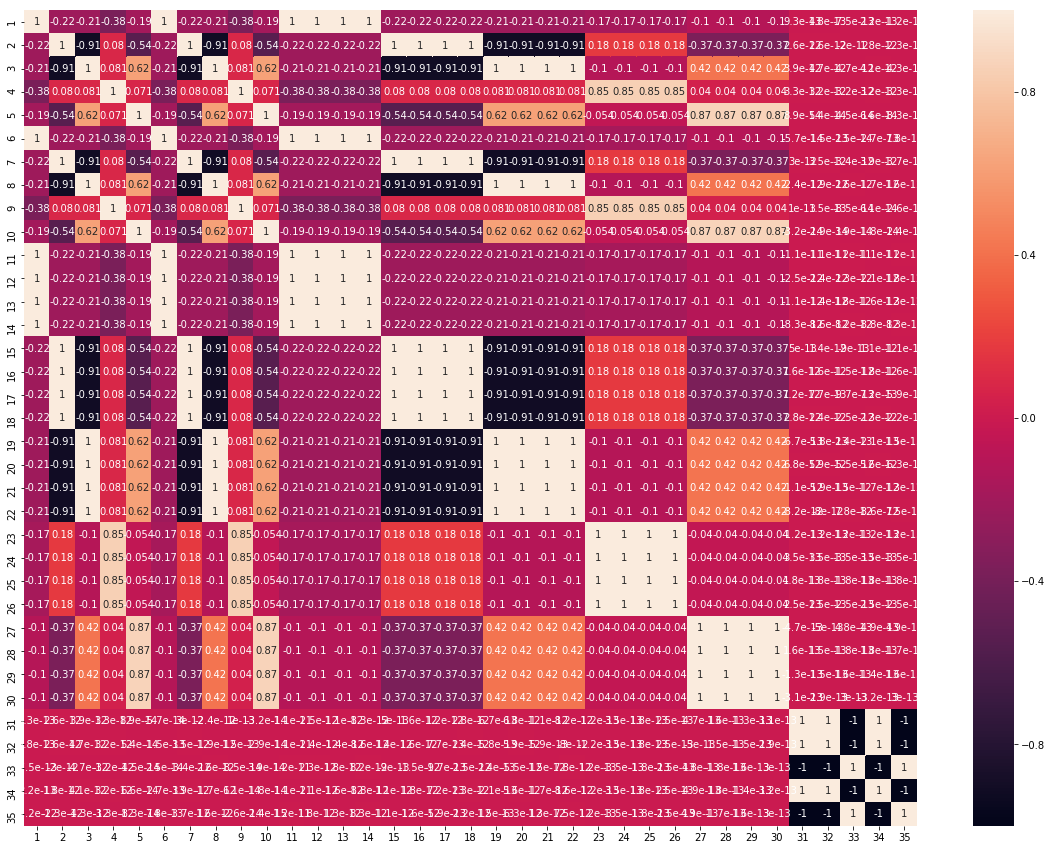

In [10]:
df_x_train.drop(columns=col_to_drop, inplace=True)
plt.figure(figsize=(20,15))
corr = df_x_train.corr()
sns.heatmap(corr, annot=True)
plt.show()

УУУ, тут на диоганальке где квадратит размера > 1 с чемто большим по модулю - такие столбцы нужно выкинуть. 

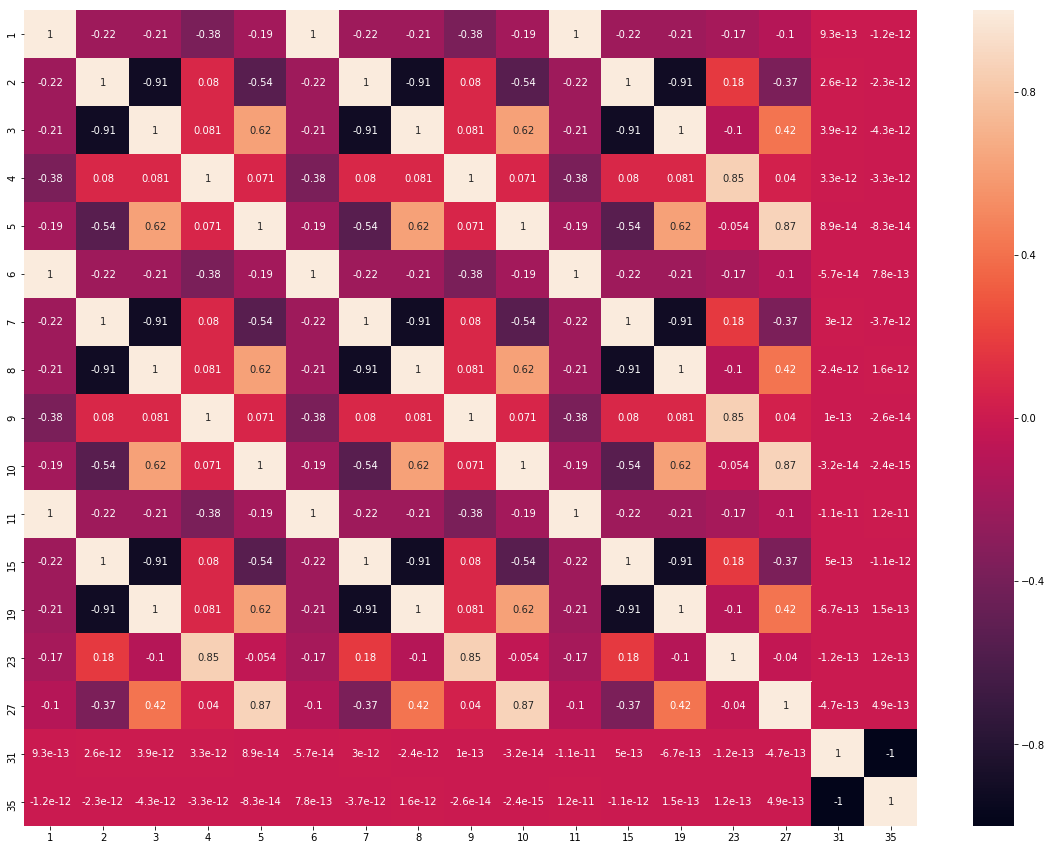

In [11]:
cor_drop = []
for i in np.linspace(d-1, 2, num=d-2, dtype=int):
    if abs(corr[i][i-1]) > 0.99:
        cor_drop.append(i)
df_x_train.drop(columns=cor_drop, inplace=True)

plt.figure(figsize=(20,15))
corr = df_x_train.corr()
sns.heatmap(corr, annot=True)
plt.show()

Кароче ещё нужно повыкидывать


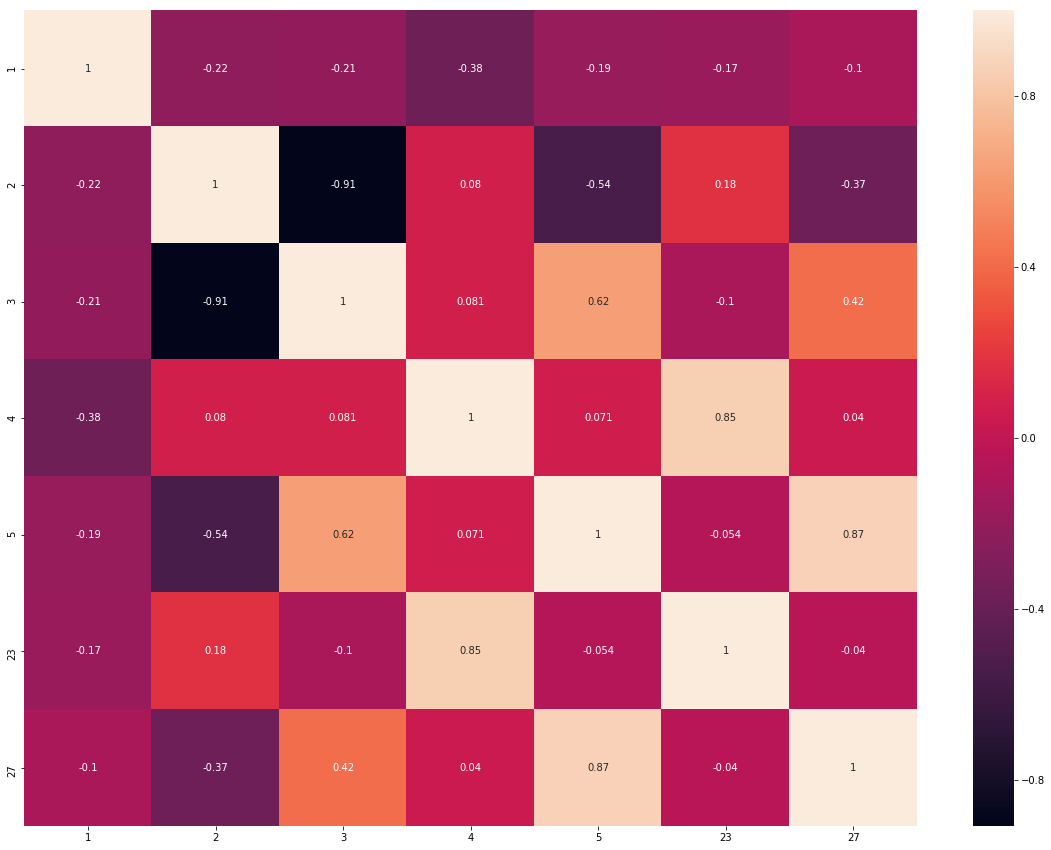

In [12]:
one_more_drop = [6, 7, 8, 9, 10, 11, 15, 19, 31, 35]
df_x_train.drop(columns=one_more_drop, inplace=True)

plt.figure(figsize=(20,15))
corr = df_x_train.corr()
sns.heatmap(corr, annot=True)
plt.show()

Матрица здорового человека.
Вот теперь то получится построить `PairPlot`

UPD это было не прост

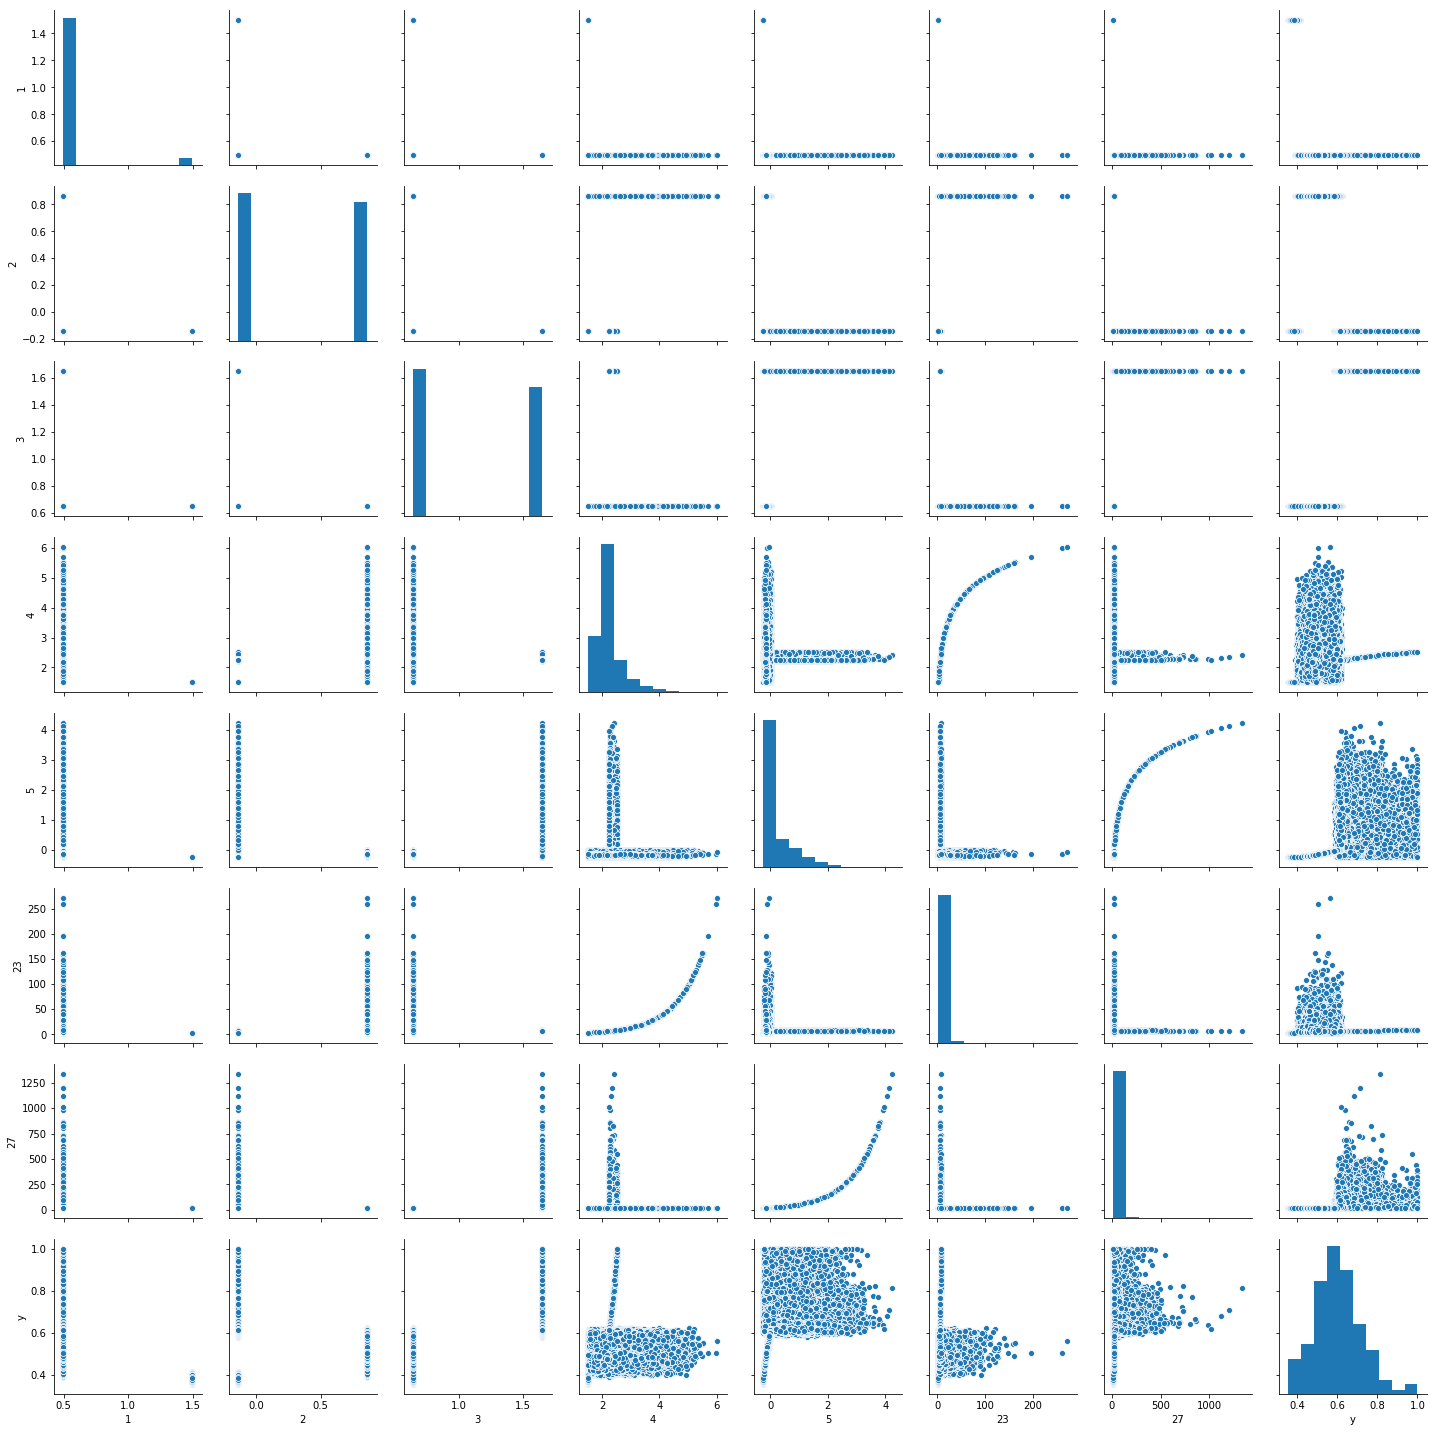

In [13]:
df_x_train['y'] = y_train.reshape(-1)
_ = sns.pairplot(df_x_train)

# Интерпретация
- Ну 1, 2, 3 - какбудто категориальные. мб это делает отображение цвета
- 4, 5, 23, 27 - очень чётко связаны с первой группой признаков. Какбудто мы видем вот эту выступающую палку, но понять что этой палки нет в основном облаке не можем.

В общем есть первые 3 важные признака категориальные, а на его основе построили вторую группу

Но закинем в моель всё, тут же отбор был, они все значимы

Пробуем модель строить, лол

In [14]:

cols = df_x_train.drop(columns=['y']).columns.tolist()
cols = [str(c) for c in cols]
rn = {}
for c in cols:
    rn[int(c)] = f'f_{c}'
# нужно переименовать колонки в строки
df_x_train = df_x_train.rename(columns=rn)

In [15]:
rel = ' '.join(['y ~', ' + '.join([f'f_{c}' for c in cols])])
rel

'y ~ f_1 + f_2 + f_3 + f_4 + f_5 + f_23 + f_27'

In [16]:
model1 = sm.OLS.from_formula(rel, data=df_x_train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                 6.157e+04
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        20:41:01   Log-Likelihood:             2.2548e+05
No. Observations:              172744   AIC:                        -4.509e+05
Df Residuals:                  172737   BIC:                        -4.509e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1974      0.001    343.204      0.000       0.196       0.198
f_1           -0.0076      0.001    -13.221      0.000      -0.009      -0.006
f_2            0.1246      0.001    219.625      0.000       0.123       0.126
f_3            0.2789      0.001    447.146      0.000       0.278       0.280
f_4            0.0321      0.001     42.007      0.000       0.031       0.034
f_5            0.0266      0.001     35.244      0.000       0.025       0.028
f_23          -0.0016   5.97e-05    -26.782      0.000      -0.002      -0.001
f_27          -0.0003   1.15e-05    -27.459      0.000      -0.000      -0.000
==============================================================================
Omnibus:                    41294.228   Durbin-Watson:                   0.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           125232.942
Skew:                           1.237   Prob(JB):                         0.00
Kurtosis:                       6.359   Cond. No.                     3.55e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.42e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

R2 маленький
# Межфакторные взаимодействия
Пробежимся по всем возможным парам признаков.
Посмотрим на BIC, имело ли смысл добавлят этот признак (чем меньше тем лучше)

In [17]:
bic_for_c = {}
features = df_x_train.columns.tolist()[:-1]
for i in range(len(features)):
    for j in range(i+1, len(features)): 
        c1 = features[i]
        c2 = features[j]
        model = sm.GLM.from_formula(f'{rel}+{c1}:{c2}', data=df_x_train).fit()               
        for feat_comb, p in model.pvalues.items():
            if p < 0.05 and ':' in feat_comb:
                bic_for_c[f'{c1}:{c2}'] = model.bic

In [18]:
min_bic = min(list(bic_for_c.values()))
for f in bic_for_c:
    if bic_for_c[f] - min_bic < 5:
        print(f'{f}\n\tg than min {bic_for_c[f] - min_bic}')

f_2:f_4
	g than min 4.96901112771593
f_2:f_23
	g than min 0.0
f_3:f_4
	g than min 4.96901112771593
f_3:f_23
	g than min 0.0


Понятно, берём те что по нулику

In [19]:
rel_1 = rel + ' + f_2:f_4 + f_2:f_23 + f_3:f_4+ f_3:f_4 + f_3:f_23'

In [20]:
model1 = sm.OLS.from_formula(rel_1, data=df_x_train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 2.320e+05
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        20:41:12   Log-Likelihood:             3.3947e+05
No. Observations:              172744   AIC:                        -6.789e+05
Df Residuals:                  172735   BIC:                        -6.788e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3184      0.002    135.701      0.000       0.314       0.323
f_1            0.1089      0.000    243.952      0.000       0.108       0.110
f_2           -0.8117      0.025    -32.026      0.000      -0.861      -0.762
f_3            1.3416      0.030     44.085      0.000       1.282       1.401
f_4           -0.1444      0.003    -49.544      0.000      -0.150      -0.139
f_5            0.0264      0.000     67.567      0.000       0.026       0.027
f_23          -0.0263      0.001    -19.018      0.000      -0.029      -0.024
f_27          -0.0003   5.96e-06    -52.213      0.000      -0.000      -0.000
f_2:f_4        1.1093      0.020     56.538      0.000       1.071       1.148
f_2:f_23      -0.2060      0.002   -123.645      0.000      -0.209      -0.203
f_3:f_4       -1.2522      0.022    -57.942      0.000      -1.295      -1.210
f_3:f_23       0.3146      0.004     72.911      0.000       0.306       0.323
==============================================================================
Omnibus:                    14658.392   Durbin-Watson:                   0.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27346.081
Skew:                          -0.595   Prob(JB):                         0.00
Kurtosis:                       4.544   Cond. No.                     5.86e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.15e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Природа очистилась, посмотрите как хорош теперь R2.

Думаю теперь можно предсказывать картинку

In [24]:
rs_x_test = np.reshape(x_test, (x_test.shape[0] * x_test.shape[1], -1))
df_x_test = pd.DataFrame(rs_x_test, columns = [i for i in range(1,d+1)])
df_x_test.drop(columns=col_to_drop, inplace=True)
df_x_test.drop(columns=one_more_drop, inplace=True)


cols = df_x_test.columns.tolist()
cols = [str(c) for c in cols]
rn = {}
for c in cols:
    rn[int(c)] = f'f_{c}'
# нужно переименовать колонки в строки
df_x_test = df_x_test.rename(columns=rn)

# Получение изображения

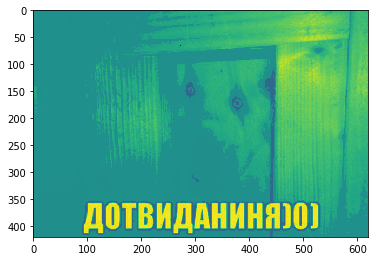

In [25]:
prediction = model1.predict(df_x_test)
y_test = prediction.values.reshape(x_test.shape[0], x_test.shape[1])
fig, ax = plt.subplots()

ax.imshow(y_test)

fig.set_figwidth(6)   
fig.set_figheight(6)    

plt.show()

Както не оч